# Fraud Detection with Cost-Sensitive Decision Making

## Executive Summary

This project builds a fraud detection system using transactional and behavioral data, emphasizing realistic validation and cost-aware decision-making. A baseline logistic model establishes initial signal, while a gradient boosting upgrade improves fraud capture and reduces operational burden. Using a time-based split and a cost-driven threshold, the final model captures approximately 75% of fraudulent transactions while flagging only 20% of total volume. Stable performance on a held-out test set confirms the system’s robustness and deployment readiness.

---

## Overview

This project builds a fraud detection system using online transaction and identity data, emphasizing realistic validation, cost-aware decision-making, and operational interpretability. Rather than optimizing leaderboard metrics, the focus is on constructing a deployable risk-scoring pipeline aligned with real-world fraud constraints.

Key elements include:
- Time-based validation to prevent temporal leakage
- Transparent baseline modeling
- Cost-sensitive threshold selection
- Gradient boosting for improved risk separation
- One-time held-out test evaluation

---

## Data

The project uses the **IEEE-CIS Fraud Detection** dataset, originally released as part of a Kaggle competition.

- Transaction-level behavioral features
- Identity and device information
- Highly imbalanced fraud labels
- Anonymized high-dimensional signals

---

## Problem Framing

The goal is to detect fraudulent transactions while minimizing expected business loss. False negatives incur direct financial cost, while false positives create customer friction and operational burden. As a result, model evaluation emphasizes recall, precision, review rate, and expected loss rather than accuracy or ROC-AUC alone.

---

## Validation Strategy

Transactions are split chronologically using the transaction timestamp:

- 70% training
- 15% validation
- 15% test (held out until final evaluation)

This approach reflects real-world deployment and avoids information leakage caused by random sampling across the entire data set.

---

## Modeling Approach

### Baseline Model

A logistic regression model using a small set of transparent features establishes a performance floor:

- Log-transformed transaction amount
- Transaction velocity proxies
- Identity presence indicators
- Temporal features

**Validation PR-AUC:** 0.14

### Gradient Boosting Upgrade

A gradient boosting model (XGBoost) incorporates nonlinear interactions and high-dimensional anonymized features to improve risk ranking.

**Validation PR-AUC:** 0.44  
**Test PR-AUC:** 0.45

---

## Cost-Sensitive Thresholding

Model scores are converted into decisions using a cost framework:

- Missed fraud (FN): high financial cost
- False positives (FP): lower customer and operational cost

Thresholds are selected on the validation set to minimize expected loss and then frozen for test evaluation.

---

## Final Results

| Model | Split | PR-AUC | Recall | Precision | Review Rate |
|---|---|---|---|---|---|
| Logistic Regression | Validation | 0.144 | 0.605 | 0.090 | 23.2% |
| XGBoost | Validation | 0.438 | 0.735 | 0.132 | 19.2% |
| **XGBoost** | **Test** | **0.453** | **0.748** | **0.130** | **20.0%** |

The final model captures approximately 75% of fraudulent transactions while flagging about 20% of total volume, demonstrating strong generalization and operational viability.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score

%matplotlib inline

In [ ]:
tx = pd.read_csv("data/raw/train_transaction.csv")
idn = pd.read_csv("data/raw/train_identity.csv")
df_raw = tx.merge(idn, on="TransactionID", how="left")

df_raw.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


/var/folders/s_/l4dd894n6qg3xk_w50rc8qjw0000gn/T/ipykernel_9893/3556750410.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_raw["week"] = df_raw["TransactionDT"] // (3600 * 24 * 7)


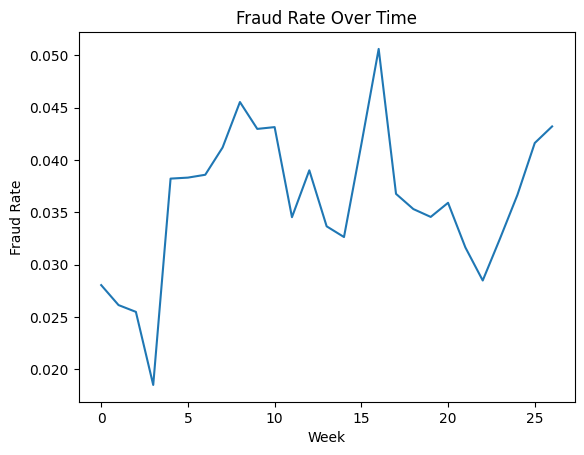

In [13]:
df_raw["week"] = df_raw["TransactionDT"] // (3600 * 24 * 7)

weekly = (
    df_raw.groupby("week")
      .agg(
          fraud_rate=("isFraud", "mean"),
          volume=("isFraud", "size")
      )
)

plt.figure()
plt.plot(weekly.index, weekly["fraud_rate"])
plt.xlabel("Week")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate Over Time")
plt.show()

> Figure 1. Fraud rate varies significantly over time, indicating non-stationarity. This motivates a time-based validation strategy and highlights the risk of temporal leakage when using random data splits and cross-validation.

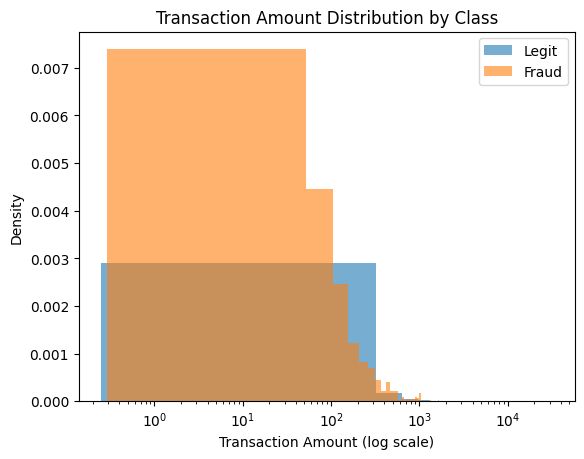

In [14]:
plt.figure()

plt.hist(
    df_raw.loc[df_raw["isFraud"] == 0, "TransactionAmt"],
    bins=100,
    alpha=0.6,
    density=True,
    label="Legit"
)

plt.hist(
    df_raw.loc[df_raw["isFraud"] == 1, "TransactionAmt"],
    bins=100,
    alpha=0.6,
    density=True,
    label="Fraud"
)

plt.xscale("log")
plt.xlabel("Transaction Amount (log scale)")
plt.ylabel("Density")
plt.legend()
plt.title("Transaction Amount Distribution by Class")
plt.show()

> Figure 2. Fraudulent transactions exhibit heavier tails but substantial overlap with legitimate transactions. This overlap underscores the need for multi-signal models rather than simple amount-based rules.

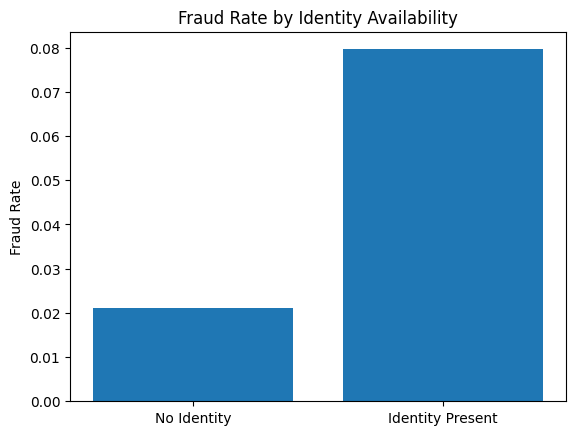

In [17]:
df_raw["has_identity"] = df_raw["DeviceType"].notna()

identity_fraud = (
    df_raw.groupby("has_identity")["isFraud"]
      .mean()
      .reset_index()
)

plt.figure()
plt.bar(identity_fraud["has_identity"], identity_fraud["isFraud"])
plt.xticks([0, 1], ["No Identity", "Identity Present"])
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Identity Availability")
plt.show()

> Figure 3. Transactions with identity information present exhibit higher fraud rates. This suggests identity collection is correlated with elevated risk, likely due to step-up authentication triggered during suspicious sessions.

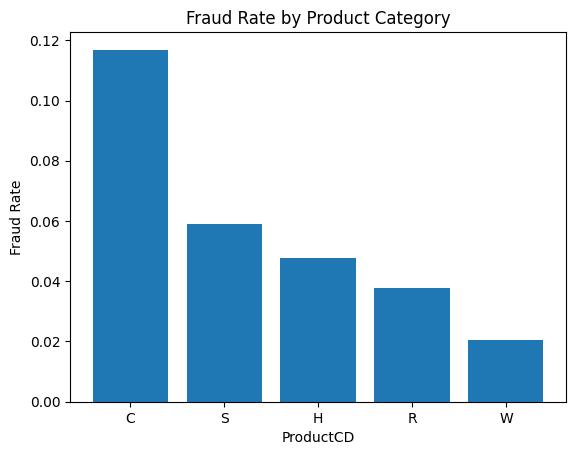

In [18]:
prod = (
    df_raw.groupby("ProductCD")
      .agg(
          fraud_rate=("isFraud", "mean"),
          volume=("isFraud", "size")
      )
      .sort_values("fraud_rate", ascending=False)
)

plt.figure()
plt.bar(prod.index, prod["fraud_rate"])
plt.ylabel("Fraud Rate")
plt.xlabel("ProductCD")
plt.title("Fraud Rate by Product Category")
plt.show()

> Figure 4. Fraud risk is unevenly distributed across product categories, with a small subset exhibiting elevated rates. This motivates category-aware features and careful smoothing to avoid overfitting on low-volume segments.

## Data Split

To reflect real-world deployment and avoid temporal leakage, we split the data chronologically using the transaction timestamp. Models are trained on early transactions, tuned on a subsequent validation window, and evaluated on a final held-out test set. This approach captures non-stationarity in fraud behavior and provides a realistic estimate of out-of-sample performance.

In [25]:
# Order transactions by date
df_raw = df_raw.sort_values("TransactionDT")

# Implement initial train/val/test split to have a 70/15/15 allocation
n = len(df_raw)

train_end = int(0.70 * n)
val_end   = int(0.85 * n)

train_df = df_raw.iloc[:train_end]
val_df   = df_raw.iloc[train_end:val_end]
test_df  = df_raw.iloc[val_end:]

# Double-check splits (no print implies splits are good)
assert train_df["TransactionDT"].max() <= val_df["TransactionDT"].min()
assert val_df["TransactionDT"].max() <= test_df["TransactionDT"].min()


In [ ]:
# Inspect fraud rates to confirm reasonable representation in each split
for name, split in zip(
    ["Train", "Validation", "Test"],
    [train_df, val_df, test_df]
):
    print(name, split["isFraud"].mean())


Train 0.03516878014795175
Validation 0.03434145019812375
Test 0.03480430340592226


## Baseline Decision Support

> How well can we do with obvious, defensible signals?

### Define Features

We begin by creating a subset of interpretable features to use as a baseline measure of fraud detection potential.

In [39]:
# Log-transform transaction amount
for split in [train_df, val_df, test_df]:
    split["log_amt"] = np.log1p(split["TransactionAmt"])

# Boolean fo rhaving identity information
for split in [train_df, val_df, test_df]:
    split["has_identity"] = split["DeviceType"].notna().astype(int)

# Extract the hour of the transaction and apply some transforms
for split in [train_df, val_df, test_df]:
    split["hour"] = (split["TransactionDT"] // 3600) % 24
    split["hour_sin"] = np.sin(2 * np.pi * split["hour"] / 24)
    split["hour_cos"] = np.cos(2 * np.pi * split["hour"] / 24)

# Card velocity
card_counts = (
    train_df.groupby("card1")["TransactionID"]
    .count()
    .to_dict()
)

for split in [train_df, val_df, test_df]:
    split["card1_count"] = split["card1"].map(card_counts).fillna(0)

# Email domain frequency
email_freq = (
    train_df["P_emaildomain"]
    .value_counts(normalize=True)
    .to_dict()
)

for split in [train_df, val_df, test_df]:
    split["email_freq"] = split["P_emaildomain"].map(email_freq).fillna(0)

# Define numeric and categorical features for pipelines
from sklearn.preprocessing import OneHotEncoder

cat_features = ["ProductCD"]
num_features = [
    "log_amt",
    "card1_count",
    "has_identity",
    "hour_sin",
    "hour_cos",
    "email_freq"
]



/var/folders/s_/l4dd894n6qg3xk_w50rc8qjw0000gn/T/ipykernel_9893/2838202548.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  split["hour_sin"] = np.sin(2 * np.pi * split["hour"] / 24)
/var/folders/s_/l4dd894n6qg3xk_w50rc8qjw0000gn/T/ipykernel_9893/2838202548.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  split["hour_cos"] = np.cos(2 * np.pi * split["hour"] / 24)
/var/folders/s_/l4dd894n6qg3xk_w50rc8qjw0000gn/T/ipykernel_9893/2838202548.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

### Define Model and Pipeline

In [ ]:
# Define pre-processing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_features),
        ("num", "passthrough", num_features)
    ]
)

# Defien modeling pipeline
model = Pipeline(
    steps=[
        ("prep", preprocess),
        ("clf", LogisticRegression(
            max_iter=2000,
            class_weight="balanced"
        ))
    ]
)

# Fit model
model.fit(train_df[cat_features + num_features], train_df["isFraud"])


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spa

### Evaluate Baseline Performance

In [43]:
from sklearn.metrics import average_precision_score

val_preds = model.predict_proba(val_df[cat_features + num_features])[:, 1]

ap = average_precision_score(val_df["isFraud"], val_preds)
print(f"Validation PR-AUC: {ap:.4f}")


Validation PR-AUC: 0.1444


A logistic regression using a small set of transparent, leakage-safe features achieves a validation PR-AUC of 0.144, approximately four times higher than a random baseline. This confirms the presence of meaningful fraud signal while establishing a conservative performance floor for subsequent model improvements. We can further evaluate baseline performance by looking at "recall at a fixed review rate." For example:

> If we review the riskiest 3% of transactions, how much fraud do we catch?

In [45]:
def recall_at_k(y_true, y_score, k_frac):
    cutoff = np.quantile(y_score, 1 - k_frac)
    preds = y_score >= cutoff
    return (y_true[preds].sum() / y_true.sum())

for k in [0.01, 0.03, 0.05]:
    r = recall_at_k(val_df["isFraud"], val_preds, k)
    print(f"Recall @ top {int(k*100)}%: {r:.3f}")

Recall @ top 1%: 0.092
Recall @ top 3%: 0.211
Recall @ top 5%: 0.278


Before moving on to more complicated modeling strategies, let's use our baseline model to develop an actual decision-making system, not just a predictive tool. To do this, we will clarify our decision-making problem and define costs to certain classification decisions.

There are four types of classification decisions that our model can make:
- True Positive (TP)
    - Fraud correctly identified.
- False Negative (FN)
    - Fraud missed (monetary loss)
- False Positive (FP)
    - Legitimate transaction flagged (friction)
- True Negative (TN)
    - Legitimate transaction approved

As a starting point, we'll make the following cost assumptions for each decision:
- TP: $0
- FN: $500
- FP: $20
- TN: $0

In [62]:
# Define costs
COST_FN = 500
COST_FP = 20
COST_TP = 0
COST_TN = 0

# Compute expected loss by threshold
thresholds = np.linspace(0, 1, 200)
losses = []

# Use validation set for evaluation
y_true = val_df["isFraud"].values
y_score = val_preds

# Iterate across thresholds and compute monetary loss
for t in thresholds:
    preds = (y_score >= t).astype(int)

    fp = ((preds == 1) & (y_true == 0)).sum()
    fn = ((preds == 0) & (y_true == 1)).sum()

    total_loss = COST_FP * fp + COST_FN * fn
    losses.append(total_loss)

# Aggregate loss estimates
losses = np.array(losses)

# Find the optimal decision threshold
best_idx = losses.argmin()
best_threshold = thresholds[best_idx]
best_threshold

# Make prediction decision
best_preds = (y_score >= best_threshold).astype(int)

# Compute metrics
precision = precision_score(y_true, best_preds)
recall = recall_score(y_true, best_preds)
review_rate = best_preds.mean()

# Summarise performance
print("Threshold:  ", best_threshold) # Note, it is not the default 0.5!
print("Precision:  ", precision)
print("Recall:     ", recall)
print("Review Rate:", review_rate)

Threshold:   0.4824120603015075
Precision:   0.08955586904703994
Recall:      0.6051939513477975
Review Rate: 0.23207008274912228


Using a cost-based framework that assigns higher cost to missed fraud than to false positives, the optimal decision threshold captures approximately 60% of fraudulent transactions on the validation set. Achieving this level of recall requires flagging roughly 23% of transactions, resulting in a precision of about 9%, which is materially higher than the base fraud rate. While this review rate would be impractical for manual investigation, it highlights the tradeoff between recall and operational capacity and motivates the use of more expressive models or tiered decision strategies. These results confirm that the baseline model captures meaningful fraud signal while leaving substantial room for improvement.

In practice, such a threshold could support automated declines at the highest risk levels, with downstream models or business rules handling mid-risk transactions.

## Improving Upon the Baseline

In [64]:
# Base features
base_features = [
    "log_amt",
    "card1_count",
    "has_identity",
    "hour_sin",
    "hour_cos",
    "email_freq"
]

# Anonymized features
v_features = [c for c in train_df.columns if c.startswith("V")]

# Aggregate
features = base_features + v_features
print("Num Features: ", len(features))

Num Features:  345


In [ ]:
# Define train and test sets
X_train = train_df[features]
y_train = train_df["isFraud"]

X_val = val_df[features]
y_val = val_df["isFraud"]

# Define XGB model
gbm = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)

# Fit model
gbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_metho

In [75]:
# Compute metrics using default decision threshold
val_scores_gbm = gbm.predict_proba(X_val)[:, 1]
ap_gbm = average_precision_score(y_val, val_scores_gbm)

print(f"Validation PR-AUC Baseline: {ap:.4f}")
print(f"Validation PR-AUC XGBoost:  {ap_gbm:.4f}")

Validation PR-AUC Baseline: 0.1444
Validation PR-AUC XGBoost:  0.4381


In [76]:
thresholds = np.linspace(0, 1, 300)
losses = []

for t in thresholds:
    preds = (val_scores_gbm >= t).astype(int)
    fp = ((preds == 1) & (y_val == 0)).sum()
    fn = ((preds == 0) & (y_val == 1)).sum()
    losses.append(COST_FP * fp + COST_FN * fn)

losses = np.array(losses)
best_idx = losses.argmin()
best_threshold_gbm = thresholds[best_idx]

best_preds_gbm = (val_scores_gbm >= best_threshold_gbm).astype(int)

precision_gbm = precision_score(y_val, best_preds_gbm)
recall_gbm = recall_score(y_val, best_preds_gbm)
review_rate_gbm = best_preds_gbm.mean()

# Summarise performance
print("Threshold:  ", best_threshold_gbm)
print("Precision:  ", precision_gbm)
print("Recall:     ", recall_gbm)
print("Review Rate:", review_rate_gbm)


Threshold:   0.4080267558528428
Precision:   0.13167972662463914
Recall:      0.7347140039447732
Review Rate: 0.19160993892595476


Applying the same cost-based thresholding framework to the gradient boosting model further improves operational performance. At the optimal threshold, the model captures approximately 73% of fraudulent transactions while reducing the proportion of flagged transactions to about 19%, compared to over 23% for the baseline model. Precision improves by roughly 45%, indicating more concentrated risk among flagged cases. These results demonstrate that the boosted model with additional features not only improves ranking quality but also translates that improvement into more efficient decision-making under realistic cost constraints.

In practice, this improvement would allow fraud operations to either reduce manual review volume at constant recall or increase fraud capture without expanding review capacity.

## Test Set Evaluation

In [78]:
# Define X and y test
X_test = test_df[features]
y_test = test_df["isFraud"]

# Get model probabilities
test_scores = gbm.predict_proba(X_test)[:, 1]

# Define probability threshold (based on validation set)
TEST_THRESHOLD = 0.4080267558528428

# Get classifications
test_preds = (test_scores >= TEST_THRESHOLD).astype(int)

# Compute metrics
test_precision = precision_score(y_test, test_preds)
test_recall = recall_score(y_test, test_preds)
test_review_rate = test_preds.mean()
test_ap = average_precision_score(y_test, test_scores)

# Summarise performance
print("Threshold:        ", TEST_THRESHOLD)
print("Precision:        ", test_precision)
print("Recall:           ", test_recall)
print("Review Rate:      ", test_review_rate)
print("Average Precision:", test_ap)

Threshold:         0.4080267558528428
Precision:         0.13038561574126428
Recall:            0.7479727538112229
Review Rate:       0.1996590691005972
Average Precision: 0.45278957090965144


| Metric      | Validation (XGBoost) | **Test (XGBoost)** |
| ----------- | -------------------- | ------------------ |
| PR-AUC      | 0.438                | **0.453**          |
| Recall      | 0.735                | **0.748**          |
| Precision   | 0.132                | **0.130**          |
| Review Rate | 19.2%                | **20.0%**          |

The final gradient boosting model was evaluated once on a held-out test set using a decision threshold fixed during validation. Test performance closely matches validation results, with a PR-AUC of 0.45, recall of approximately 75%, and a review rate near 20%. The stability of these metrics confirms that the observed gains are not driven by temporal leakage or overfitting, but instead reflect genuine improvements in risk ranking. These results indicate that the model is suitable for deployment as a first-line fraud detection system, with clear opportunities for further refinement through tiered decisioning and operational constraints.

## Key Takeaways

| Model               | Split      | PR-AUC    | Recall    | Precision | Review Rate |
| ------------------- | ---------- | --------- | --------- | --------- | ----------- |
| Logistic Regression | Validation | 0.144     | 0.605     | 0.090     | 23.2%       |
| XGBoost             | Validation | 0.438     | 0.735     | 0.132     | 19.2%       |
| **XGBoost**         | **Test**   | **0.453** | **0.748** | **0.130** | **20.0%**   |

- Temporal validation is critical for honest fraud evaluation
- Simple baselines provide valuable signal and interpretability
- Gradient boosting significantly improves risk separation
- Cost-aware thresholds translate model outputs into actionable decisions